In [2]:
import numpy as np
import pandas as pd
import os

import tensorflow as tf
import keras
from keras.utils import image_dataset_from_directory
from keras.optimizers import Adam
from keras import Sequential, Model
from keras.layers import (
    GlobalAveragePooling2D, Flatten, Input,
    Dense, Dropout, Conv2D, Conv2DTranspose, BatchNormalization, 
    MaxPooling2D, UpSampling2D, Rescaling, Resizing)
from keras.callbacks import EarlyStopping, ModelCheckpoint, Callback
from IPython.display import clear_output

from datetime import datetime
import time

from sklearn.metrics import roc_curve, auc, accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

from tensorflow.keras.applications.vgg16 import preprocess_input

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [3]:
import random
random_seed = 5
np.random.seed(random_seed)
random.seed(random_seed)
tf.random.set_seed(random_seed)

In [4]:
class PlotLearning(Callback):
    """
    Callback to plot metrics during training
    """
    def __init__(self, showLR=False):
      self.showLR = showLR                 

    def on_train_begin(self, logs={}):
        self.metrics = {}
        for metric in logs:
            self.metrics[metric] = []
            

    def on_epoch_end(self, epoch, logs={}):
        for metric in logs:
            if metric in self.metrics:
                self.metrics[metric].append(logs.get(metric))
            else:
                self.metrics[metric] = [logs.get(metric)]
        
        metric = [x for x in logs if ('val' not in x) and ('lr' not in x)]
        if self.showLR:
          metric.append('lr')
        
        f, axs = plt.subplots(1,len(metric),figsize=(10,4))
        clear_output(wait=True)
        for i,ax in enumerate(axs):
          ax.plot(range(1, epoch + 2), self.metrics[metric[i]],'o--',label=metric[i])
          try:
            ax.plot(range(1, epoch + 2), self.metrics['val_' + metric[i]], 'o--', label='val_' + metric[i])
          except:
            pass
          ax.set_xlabel('# epochs')
          ax.set_ylabel(metric[i])
          ax.legend()
          ax.grid()

        plt.tight_layout()
        plt.show()

In [5]:
def get_model_metrics(test_data, model, model_name):
    """
    Evaluates a binary classification model on test data and reports various performance metrics.
    It calculates the confusion matrix, ROC curve, and several statistical measures including accuracy, 
    sensitivity, specificity, precision, NPV (Negative Predictive Value), PLR (Positive Likelihood Ratio), 
    NLR (Negative Likelihood Ratio), and F1-score. Additionally, it identifies the best threshold for 
    classification based on F1-score optimization.

    The function saves the confusion matrix and ROC curve plots in a local directory, and appends the 
    calculated metrics to a CSV file. This file is created if it doesn't exist, or updated if it does.

    Parameters:
    - test_data (iterable): The test dataset, typically a generator or an iterable that yields batches 
      of images and labels.
    - model (keras.Model): The trained Keras model to evaluate.
    - model_name (str): The name of the model, used for saving output files.

    No return value. The function directly prints the calculated metrics and saves the results and plots 
    to the local file system.
    """
    timestamp = datetime.now().strftime("%Y%m%d%H%M%S")
    results_folder = 'results'
    csv_file = f'{results_folder}/model_performance.csv'
    
    if not os.path.exists(results_folder):
        os.makedirs(results_folder)
        
    predicted_probs = []
    true_labels = []

    for images, labels in test_data:
        predictions = model.predict(images, verbose=0)
        predicted_probs.extend(predictions.flatten())
        true_labels.extend([int(label) for label in labels])

    # determine the best threshold
    thresholds = np.linspace(0, 1, 100)
    best_f1 = 0
    best_threshold = 0.5
    for thresh in thresholds:
        predicted_labels = [1 if p > thresh else 0 for p in predicted_probs]
        f1 = f1_score(true_labels, predicted_labels)
        if f1 > best_f1:
            best_f1 = f1
            best_threshold = thresh

    print(f"Best threshold: {best_threshold:.2f} with F1-score: {best_f1:.2f}")
    
    # recalculate predictions with the best threshold
    final_predicted_labels = [1 if p > best_threshold else 0 for p in predicted_probs]
    
    # Confusion Matrix
    confusion_mtx = confusion_matrix(true_labels, final_predicted_labels)
    # plot the confusion matrix
    f,ax = plt.subplots(figsize=(8, 8))
    sns.heatmap(confusion_mtx, annot=True, linewidths=0.01,cmap="Purples",linecolor="gray", fmt= '.1f',ax=ax)
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.title("Confusion Matrix")
    plt.savefig(f'{results_folder}/{model_name}_run_{timestamp}_confusion_matrix.png')
    plt.show()
    
    # Classification report
    report = classification_report(true_labels, final_predicted_labels)
    print(report)

    # calculate additional metrics
    TP = sum((np.array(true_labels) == 1) & (np.array(final_predicted_labels) == 1))
    TN = sum((np.array(true_labels) == 0) & (np.array(final_predicted_labels) == 0))
    FP = sum((np.array(true_labels) == 0) & (np.array(final_predicted_labels) == 1))
    FN = sum((np.array(true_labels) == 1) & (np.array(final_predicted_labels) == 0))

    accuracy = accuracy_score(true_labels, final_predicted_labels)
    sensitivity = recall_score(true_labels, final_predicted_labels)  # recall
    specificity = TN / (TN + FP)
    precision = precision_score(true_labels, final_predicted_labels)  # PPV
    npv = TN / (TN + FN)
    plr = sensitivity / (1 - specificity)
    nlr = (1 - sensitivity) / specificity
    f1_pos_class = f1_score(true_labels, final_predicted_labels)

    # ROC AUC
    fpr, tpr, _ = roc_curve(true_labels, predicted_probs)
    roc_auc = auc(fpr, tpr)

    # create a DataFrame and append to the CSV file
    df = pd.DataFrame({
        'Model Name': [model_name],
        'AUC': [roc_auc],
        'F1-Score Positive Class': [f1_pos_class],
        'Accuracy': [accuracy],
        'Sensitivity': [sensitivity],
        'Specificity': [specificity],
        'PPV': [precision],
        'NPV': [npv],
        'PLR': [plr],
        'NLR': [nlr]
    }).round(2) 

    if os.path.exists(csv_file):
        df.to_csv(csv_file, mode='a', header=False, index=False)
    else:
        df.to_csv(csv_file, index=False)

    print(df)

    # plotting and saving ROC Curve
    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = {:.2f})'.format(roc_auc))
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic')
    plt.legend(loc='lower right')
    plt.savefig(f'{results_folder}/{model_name}_run_{timestamp}_roc_curve.png')
    plt.show()

In [7]:
train_data = tf.keras.utils.image_dataset_from_directory(
    '/input/c3-11-mask/cropped_train',
    batch_size=32,
    image_size=(224, 224),
    color_mode='grayscale',
    label_mode='binary',
    class_names=['healthy', 'unhealthy']  # Assign class 0 to healthy and class 1 to unhealthy                                              
)

val_data = tf.keras.utils.image_dataset_from_directory(
    '/input/c3-11-mask/cropped_validation',
    batch_size=32,
    image_size=(224, 224),
    color_mode='grayscale',
    label_mode='binary',
    class_names=['healthy', 'unhealthy']
)

test_data = tf.keras.utils.image_dataset_from_directory(
    '/input/c3-11-mask/cropped_test',
    batch_size=32,
    image_size=(224, 224),
    color_mode='grayscale',
    label_mode='binary',
    class_names=['healthy', 'unhealthy']
)

Found 742 files belonging to 2 classes.
Found 156 files belonging to 2 classes.
Found 166 files belonging to 2 classes.


In [8]:
METRICS = [
       keras.metrics.AUC(name='auc'),
]

# Define a function to build a model transforming first layer to take grayscale

In [9]:
def build_model(base_model, transfer_learning):
    """
    Constructs a neural network model based on a specified base model and a transfer learning option.

    This function initializes a new model by setting the base model's trainable parameter according to 
    the transfer_learning flag ('Y' for non-trainable and 'N' for trainable). It modifies the input 
    layer to accommodate grayscale images and expands the single channel to three channels using a 
    Conv2D layer. The function then applies the base model and adds additional top layers for classification. 
    It returns the newly created model, which is suitable for binary classification tasks.

    Parameters:
    - base_model (keras.Model): The pre-existing model to use as the base.
    - transfer_learning (str): A flag ('Y' or 'N') indicating whether to freeze (non-trainable) or unfreeze 
      (trainable) the layers of the base model for transfer learning.

    Returns:
    - keras.Model: The constructed model ready for training.
    """
    # Set the base_model to be trainable or non-trainable
    if transfer_learning == 'Y':
        base_model.trainable = False
    elif transfer_learning == 'N':
        base_model.trainable = True
    print('base_model.trainable set to', base_model.trainable)

    # Define a new input layer for grayscale images
    input_layer = Input(shape=(224, 224, 1), name='grayscale_input')

    # Add a Conv2D layer to expand the single channel to three channels
    x = Conv2D(3, (3, 3), padding='same')(input_layer)

    # Add the rest of the model
    x = base_model(x)

    # Add own top layers for classification
    x = GlobalAveragePooling2D()(x)
    outputs = Dense(1, activation='sigmoid')(x)

    # Create the new model
    model = Model(inputs=input_layer, outputs=outputs)

    return model

# MobileNet (no TL)

In [10]:
from tensorflow.keras.applications import MobileNet

In [36]:
def preprocess_data_mobilenet(image, label):
    # Preprocess the image for MobileNet
    image = tf.keras.applications.mobilenet.preprocess_input(image)
    return image, label

# Map the preprocessing function to the datasets
prep_train_data = train_data.map(preprocess_data_mobilenet)
prep_val_data = val_data.map(preprocess_data_mobilenet)
prep_test_data = test_data.map(preprocess_data_mobilenet)


In [37]:
# load the model
base_mobilenet = tf.keras.applications.MobileNet(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# build the model
model_mobilenet = build_model(base_model=base_mobilenet, transfer_learning='N')

# model summary
model_mobilenet.summary()

base_model.trainable set to True
Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 grayscale_input (InputLaye  [(None, 224, 224, 1)]     0         
 r)                                                              
                                                                 
 conv2d_4 (Conv2D)           (None, 224, 224, 3)       30        
                                                                 
 mobilenet_1.00_224 (Functi  (None, 7, 7, 1024)        3228864   
 onal)                                                           
                                                                 
 global_average_pooling2d_4  (None, 1024)              0         
  (GlobalAveragePooling2D)                                       
                                                                 
 dense_6 (Dense)             (None, 1)                 1025      
                          

In [38]:
# Compilación de la red
model_mobilenet.compile(optimizer=Adam(learning_rate=1e-3), loss='binary_crossentropy', metrics=METRICS)

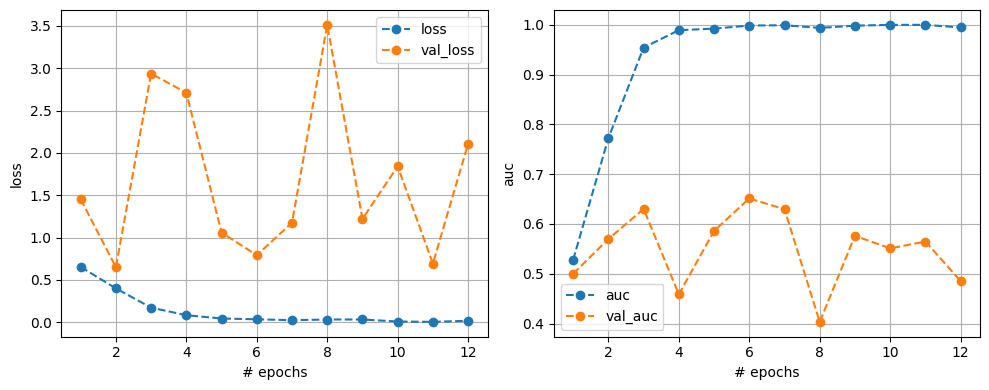

24/24 [==============================] - 5s 159ms/step - loss: 0.0175 - auc: 0.9947 - val_loss: 2.1081 - val_auc: 0.4854
Training time: 72.84992623329163 seconds


In [39]:
# Entrenamiento de la red
mob_callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)
mob_checkpoint = ModelCheckpoint('mob_best_weights.h5', save_best_only=True, save_weights_only=True)
mob_plot_callback = PlotLearning()

start = time.time()

history = model_mobilenet.fit(prep_train_data,
                    epochs=150,
                    validation_data=prep_val_data,
                    callbacks=[mob_callback, mob_checkpoint, mob_plot_callback]
                    )

end = time.time()

print('Training time:', end - start, 'seconds')

Best threshold: 0.96 with F1-score: 0.39


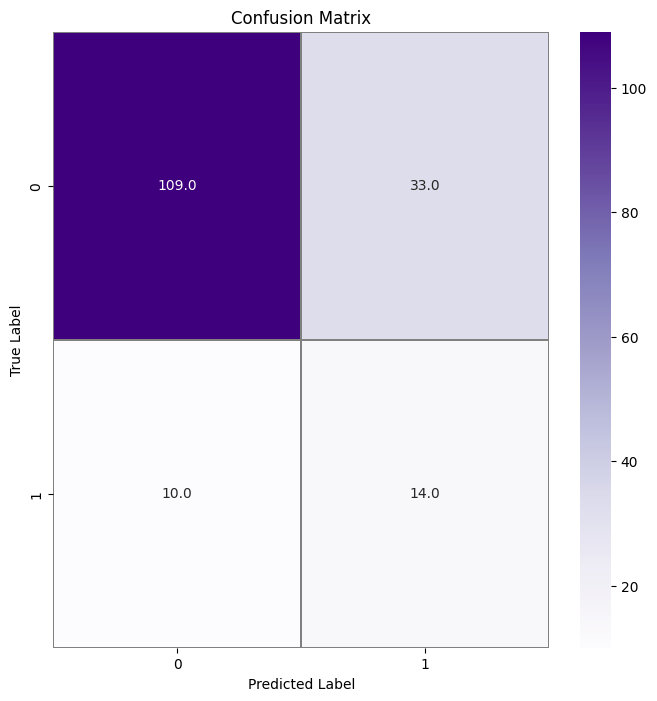

        Model Name   AUC  F1-Score Positive Class  Accuracy  Sensitivity  \
0  MobileNet-no-TL  0.63                     0.39      0.74         0.58   

   Specificity  PPV   NPV   PLR   NLR  
0         0.77  0.3  0.92  2.51  0.54  


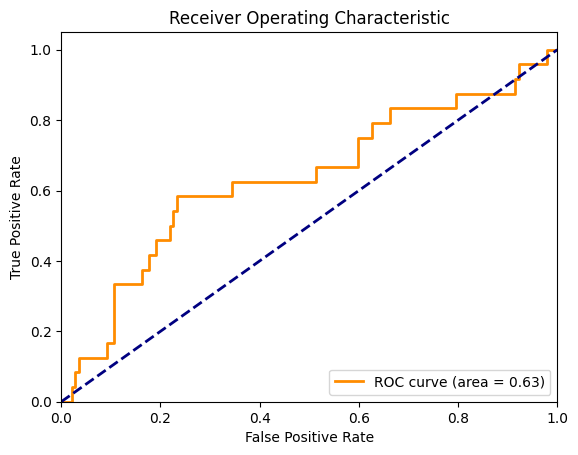

In [40]:
get_model_metrics(test_data=prep_test_data, model=model_mobilenet, model_name='MobileNet-no-TL')

# Train on anterior placental images only

In [11]:
train_data = tf.keras.utils.image_dataset_from_directory(
    '/input/a-c3-11-mask/cropped_train',
    batch_size=32,
    image_size=(224, 224),
    color_mode='grayscale',
    label_mode='binary',
    class_names=['healthy', 'unhealthy']  # Assign class 0 to healthy and class 1 to unhealthy                                              
)

val_data = tf.keras.utils.image_dataset_from_directory(
    '/input/a-c3-11-mask/cropped_validation',
    batch_size=32,
    image_size=(224, 224),
    color_mode='grayscale',
    label_mode='binary',
    class_names=['healthy', 'unhealthy']
)

test_data = tf.keras.utils.image_dataset_from_directory(
    '/input/a-c3-11-mask/cropped_test',
    batch_size=32,
    image_size=(224, 224),
    color_mode='grayscale',
    label_mode='binary',
    class_names=['healthy', 'unhealthy']
)

Found 384 files belonging to 2 classes.
Found 81 files belonging to 2 classes.
Found 84 files belonging to 2 classes.


In [12]:
def preprocess_data_mobilenet(image, label):
    # Preprocess the image for MobileNet
    image = tf.keras.applications.mobilenet.preprocess_input(image)
    return image, label

# Map the preprocessing function to the datasets
prep_train_data = train_data.map(preprocess_data_mobilenet)
prep_val_data = val_data.map(preprocess_data_mobilenet)
prep_test_data = test_data.map(preprocess_data_mobilenet)


In [13]:
# load the model
base_mobilenet = tf.keras.applications.MobileNet(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# build the model
model_mobilenet = build_model(base_model=base_mobilenet, transfer_learning='N')

# model summary
model_mobilenet.summary()

17225924/17225924 [==============================] - 0s 0us/step
base_model.trainable set to True
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 grayscale_input (InputLaye  [(None, 224, 224, 1)]     0         
 r)                                                              
                                                                 
 conv2d (Conv2D)             (None, 224, 224, 3)       30        
                                                                 
 mobilenet_1.00_224 (Functi  (None, 7, 7, 1024)        3228864   
 onal)                                                           
                                                                 
 global_average_pooling2d (  (None, 1024)              0         
 GlobalAveragePooling2D)                                         
                                                                 
 dense (Dense)               

In [14]:
# Compilación de la red
model_mobilenet.compile(optimizer=Adam(learning_rate=1e-3), loss='binary_crossentropy', metrics=METRICS)

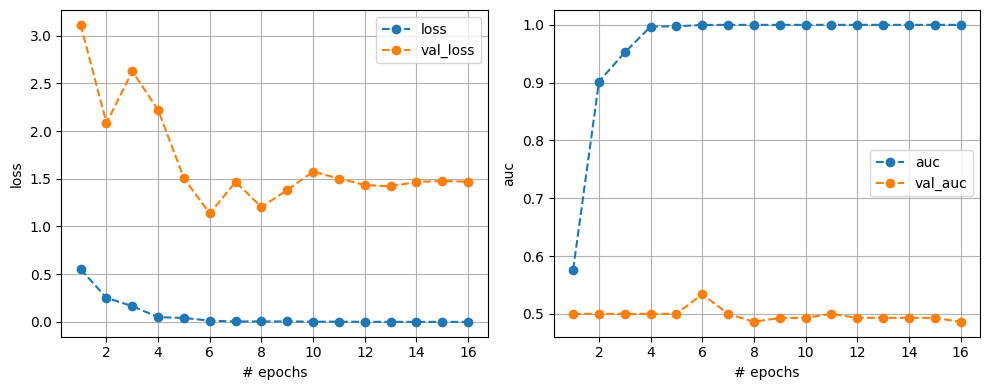

12/12 [==============================] - 3s 179ms/step - loss: 1.5940e-04 - auc: 1.0000 - val_loss: 1.4697 - val_auc: 0.4861
Training time: 79.9440176486969 seconds


In [15]:
# Entrenamiento de la red
mob_callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)
mob_checkpoint = ModelCheckpoint('mob_best_weights.h5', save_best_only=True, save_weights_only=True)
mob_plot_callback = PlotLearning()

start = time.time()

history = model_mobilenet.fit(prep_train_data,
                    epochs=150,
                    validation_data=prep_val_data,
                    callbacks=[mob_callback, mob_checkpoint, mob_plot_callback]
                    )

end = time.time()

print('Training time:', end - start, 'seconds')

Best threshold: 0.00 with F1-score: 0.25


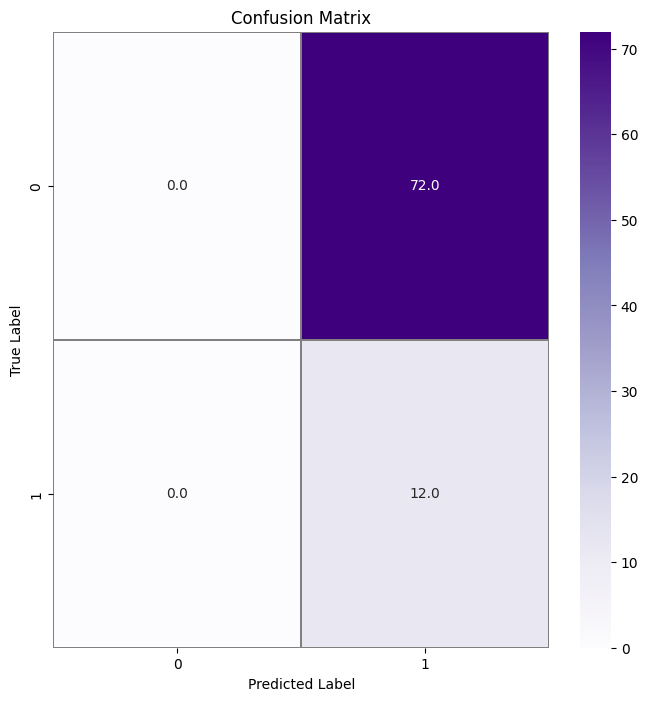

/tmp/ipykernel_42/1958539450.py:57: RuntimeWarning: invalid value encountered in scalar divide
  npv = TN / (TN + FN)
/tmp/ipykernel_42/1958539450.py:59: RuntimeWarning: invalid value encountered in scalar divide
  nlr = (1 - sensitivity) / specificity


                 Model Name   AUC  F1-Score Positive Class  Accuracy  \
0  MobileNet-no-TL-anterior  0.61                     0.25      0.14   

   Sensitivity  Specificity   PPV  NPV  PLR  NLR  
0          1.0          0.0  0.14  NaN  1.0  NaN  


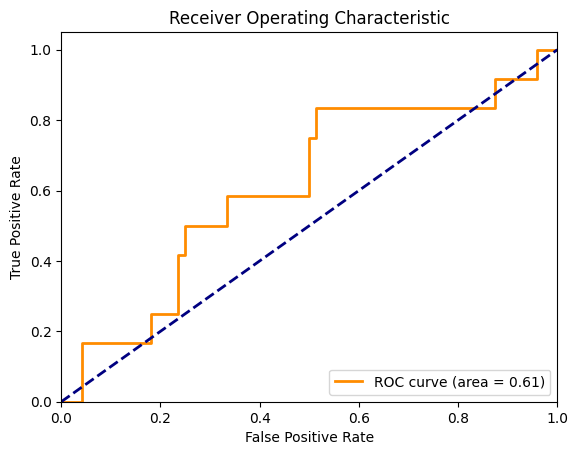

In [16]:
get_model_metrics(test_data=prep_test_data, model=model_mobilenet, model_name='MobileNet-no-TL-anterior')

# Train on posterior placental images only

In [18]:
train_data = tf.keras.utils.image_dataset_from_directory(
    '/input/p-c3-11-mask/cropped_train',
    batch_size=32,
    image_size=(224, 224),
    color_mode='grayscale',
    label_mode='binary',
    class_names=['healthy', 'unhealthy']  # Assign class 0 to healthy and class 1 to unhealthy                                              
)

val_data = tf.keras.utils.image_dataset_from_directory(
    '/input/p-c3-11-mask/cropped_validation',
    batch_size=32,
    image_size=(224, 224),
    color_mode='grayscale',
    label_mode='binary',
    class_names=['healthy', 'unhealthy']
)

test_data = tf.keras.utils.image_dataset_from_directory(
    '/input/p-c3-11-mask/cropped_test',
    batch_size=32,
    image_size=(224, 224),
    color_mode='grayscale',
    label_mode='binary',
    class_names=['healthy', 'unhealthy']
)

Found 359 files belonging to 2 classes.
Found 72 files belonging to 2 classes.
Found 84 files belonging to 2 classes.


In [19]:
def preprocess_data_mobilenet(image, label):
    # Preprocess the image for MobileNet
    image = tf.keras.applications.mobilenet.preprocess_input(image)
    return image, label

# Map the preprocessing function to the datasets
prep_train_data = train_data.map(preprocess_data_mobilenet)
prep_val_data = val_data.map(preprocess_data_mobilenet)
prep_test_data = test_data.map(preprocess_data_mobilenet)


In [20]:
# load the model
base_mobilenet = tf.keras.applications.MobileNet(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# build the model
model_mobilenet = build_model(base_model=base_mobilenet, transfer_learning='N')

# model summary
model_mobilenet.summary()

base_model.trainable set to True
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 grayscale_input (InputLaye  [(None, 224, 224, 1)]     0         
 r)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 224, 224, 3)       30        
                                                                 
 mobilenet_1.00_224 (Functi  (None, 7, 7, 1024)        3228864   
 onal)                                                           
                                                                 
 global_average_pooling2d_1  (None, 1024)              0         
  (GlobalAveragePooling2D)                                       
                                                                 
 dense_1 (Dense)             (None, 1)                 1025      
                          

In [21]:
# Compilación de la red
model_mobilenet.compile(optimizer=Adam(learning_rate=1e-3), loss='binary_crossentropy', metrics=METRICS)

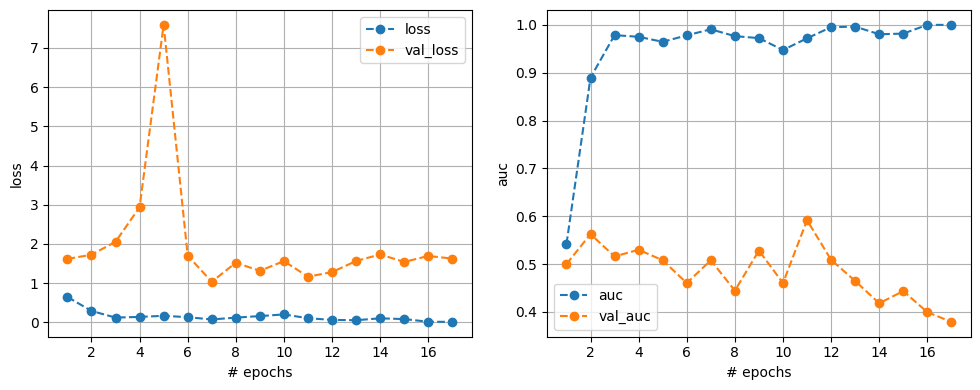

12/12 [==============================] - 3s 173ms/step - loss: 0.0117 - auc: 0.9999 - val_loss: 1.6261 - val_auc: 0.3792
Training time: 67.60544967651367 seconds


In [22]:
# Entrenamiento de la red
mob_callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)
mob_checkpoint = ModelCheckpoint('mob_best_weights.h5', save_best_only=True, save_weights_only=True)
mob_plot_callback = PlotLearning()

start = time.time()

history = model_mobilenet.fit(prep_train_data,
                    epochs=150,
                    validation_data=prep_val_data,
                    callbacks=[mob_callback, mob_checkpoint, mob_plot_callback]
                    )

end = time.time()

print('Training time:', end - start, 'seconds')

Best threshold: 0.01 with F1-score: 0.37


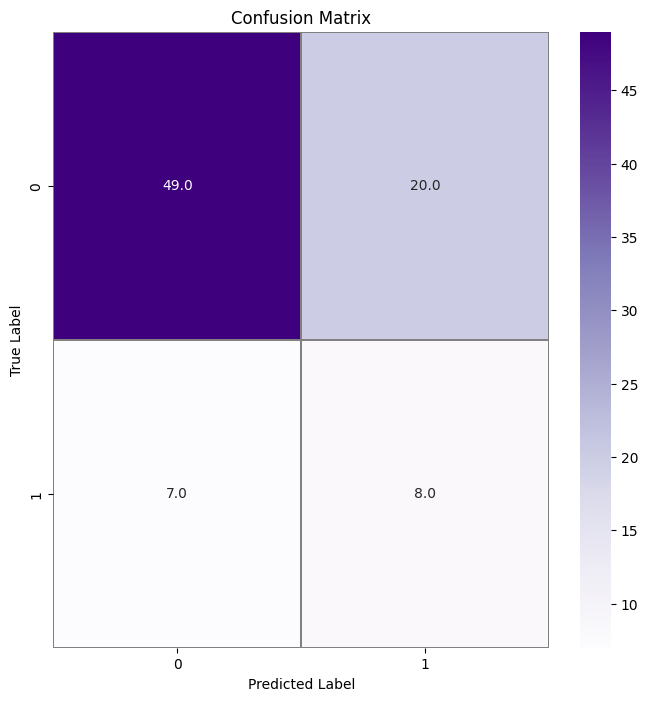

                  Model Name   AUC  F1-Score Positive Class  Accuracy  \
0  MobileNet-no-TL-posterior  0.58                     0.37      0.68   

   Sensitivity  Specificity   PPV   NPV   PLR   NLR  
0         0.53         0.71  0.29  0.88  1.84  0.66  


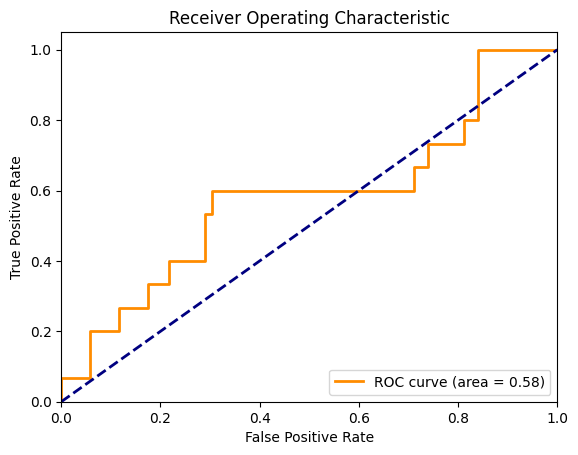

In [23]:
get_model_metrics(test_data=prep_test_data, model=model_mobilenet, model_name='MobileNet-no-TL-posterior')

# Hyperparameter tuning of best model

Best model after re-training on different planes: anterior and posterior planes combined

In [24]:
train_data = tf.keras.utils.image_dataset_from_directory(
    '/input/c3-11-mask/cropped_train',
    batch_size=32,
    image_size=(224, 224),
    color_mode='grayscale',
    label_mode='binary',
    class_names=['healthy', 'unhealthy']  # Assign class 0 to healthy and class 1 to unhealthy                                              
)

val_data = tf.keras.utils.image_dataset_from_directory(
    '/input/c3-11-mask/cropped_validation',
    batch_size=32,
    image_size=(224, 224),
    color_mode='grayscale',
    label_mode='binary',
    class_names=['healthy', 'unhealthy']
)

test_data = tf.keras.utils.image_dataset_from_directory(
    '/input/c3-11-mask/cropped_test',
    batch_size=32,
    image_size=(224, 224),
    color_mode='grayscale',
    label_mode='binary',
    class_names=['healthy', 'unhealthy']
)

Found 742 files belonging to 2 classes.
Found 156 files belonging to 2 classes.
Found 166 files belonging to 2 classes.


In [25]:
def preprocess_data_mobilenet(image, label):
    # Preprocess the image for MobileNet
    image = tf.keras.applications.mobilenet.preprocess_input(image)
    return image, label

# Map the preprocessing function to the datasets
prep_train_data = train_data.map(preprocess_data_mobilenet)
prep_val_data = val_data.map(preprocess_data_mobilenet)
prep_test_data = test_data.map(preprocess_data_mobilenet)

In [28]:
import optuna

def build_model(base_model, transfer_learning, trial):
    if transfer_learning == 'Y':
        base_model.trainable = False
    else:
        base_model.trainable = True

    input_layer = Input(shape=(224, 224, 1), name='greyscale_input')
    x = Conv2D(3, (3, 3), padding='same')(input_layer)
    x = base_model(x)
    x = GlobalAveragePooling2D()(x)

    n_layers = trial.suggest_int('n_layers', 1, 3)
    for i in range(n_layers):
        x = Dense(trial.suggest_int('units_l{}'.format(i), 50, 200), activation='relu')(x)
        dropout_rate = trial.suggest_uniform('dropout_l{}'.format(i), 0.2, 0.5)
        x = Dropout(dropout_rate)(x)

    outputs = Dense(1, activation='sigmoid')(x)
    model = Model(inputs=input_layer, outputs=outputs)
    learning_rate = trial.suggest_loguniform('learning_rate', 1e-6, 1e-4)
    model.compile(optimizer=Adam(learning_rate=learning_rate), loss='binary_crossentropy', metrics=METRICS)

    return model

def objective(trial):
    base_mobilenet = tf.keras.applications.MobileNet(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
    model_mobilenet = build_model(base_model=base_mobilenet, transfer_learning='N', trial=trial)

    mb_callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)
    mb_checkpoint = tf.keras.callbacks.ModelCheckpoint('mb_best_weights.h5', save_best_only=True, save_weights_only=True)

    start = time.time()
    history = model_mobilenet.fit(prep_train_data,
                              epochs=150,
                              validation_data=prep_val_data,
                              callbacks=[mb_callback, mb_checkpoint]
                             )
    end = time.time()
    print('Training time:', end - start, 'seconds')

    _, auc = model_mobilenet.evaluate(prep_val_data, verbose=0)
    return auc

In [29]:
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=10)

[I 2023-12-15 19:56:30,651] A new study created in memory with name: no-name-6dc3c6cf-2683-412c-b58a-b9709e125cd9


Epoch 1/150


/tmp/ipykernel_42/228322824.py:17: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout_rate = trial.suggest_uniform('dropout_l{}'.format(i), 0.2, 0.5)
/tmp/ipykernel_42/228322824.py:22: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-6, 1e-4)


24/24 [==============================] - 22s 227ms/step - loss: 0.6586 - auc: 0.5200 - val_loss: 0.5343 - val_auc: 0.5714
Epoch 2/150
24/24 [==============================] - 4s 136ms/step - loss: 0.6370 - auc: 0.5066 - val_loss: 0.5419 - val_auc: 0.5106
Epoch 3/150
24/24 [==============================] - 4s 138ms/step - loss: 0.6488 - auc: 0.4621 - val_loss: 0.5347 - val_auc: 0.5245
Epoch 4/150
24/24 [==============================] - 4s 141ms/step - loss: 0.5798 - auc: 0.5110 - val_loss: 0.5141 - val_auc: 0.5649
Epoch 5/150
24/24 [==============================] - 4s 142ms/step - loss: 0.5741 - auc: 0.5251 - val_loss: 0.4975 - val_auc: 0.5578
Epoch 6/150
24/24 [==============================] - 4s 143ms/step - loss: 0.5644 - auc: 0.5108 - val_loss: 0.4831 - val_auc: 0.5646
Epoch 7/150
24/24 [==============================] - 4s 144ms/step - loss: 0.5783 - auc: 0.4687 - val_loss: 0.4671 - val_auc: 0.5795
Epoch 8/150
24/24 [==============================] - 4s 145ms/step - loss: 0.511

[I 2023-12-15 19:58:47,597] Trial 0 finished with value: 0.5576719641685486 and parameters: {'n_layers': 3, 'units_l0': 191, 'dropout_l0': 0.44244437402912307, 'units_l1': 195, 'dropout_l1': 0.39923712490108065, 'units_l2': 121, 'dropout_l2': 0.3581578112376983, 'learning_rate': 3.1980188218501586e-06}. Best is trial 0 with value: 0.5576719641685486.


Epoch 1/150
24/24 [==============================] - 20s 170ms/step - loss: 0.6890 - auc: 0.4886 - val_loss: 0.7028 - val_auc: 0.5735
Epoch 2/150
24/24 [==============================] - 4s 150ms/step - loss: 0.4893 - auc: 0.5447 - val_loss: 0.5394 - val_auc: 0.5813
Epoch 3/150
24/24 [==============================] - 4s 143ms/step - loss: 0.4315 - auc: 0.5722 - val_loss: 0.4326 - val_auc: 0.6309
Epoch 4/150
24/24 [==============================] - 4s 144ms/step - loss: 0.3806 - auc: 0.6763 - val_loss: 0.4040 - val_auc: 0.6924
Epoch 5/150
24/24 [==============================] - 4s 151ms/step - loss: 0.3848 - auc: 0.6645 - val_loss: 0.3908 - val_auc: 0.7021
Epoch 6/150
24/24 [==============================] - 4s 140ms/step - loss: 0.3639 - auc: 0.7110 - val_loss: 0.4005 - val_auc: 0.6367
Epoch 7/150
24/24 [==============================] - 4s 142ms/step - loss: 0.3150 - auc: 0.8192 - val_loss: 0.4074 - val_auc: 0.5910
Epoch 8/150
24/24 [==============================] - 4s 140ms/step -

[I 2023-12-15 20:00:08,077] Trial 1 finished with value: 0.5541446208953857 and parameters: {'n_layers': 3, 'units_l0': 105, 'dropout_l0': 0.3053925483721698, 'units_l1': 177, 'dropout_l1': 0.3130162504923987, 'units_l2': 92, 'dropout_l2': 0.42001561082667005, 'learning_rate': 4.041954466492816e-05}. Best is trial 0 with value: 0.5576719641685486.


Epoch 1/150
24/24 [==============================] - 21s 170ms/step - loss: 0.6430 - auc: 0.5386 - val_loss: 0.5071 - val_auc: 0.5231
Epoch 2/150
24/24 [==============================] - 4s 143ms/step - loss: 0.4041 - auc: 0.6063 - val_loss: 0.4335 - val_auc: 0.5383
Epoch 3/150
24/24 [==============================] - 4s 152ms/step - loss: 0.3727 - auc: 0.6787 - val_loss: 0.4257 - val_auc: 0.5840
Epoch 4/150
24/24 [==============================] - 4s 138ms/step - loss: 0.3806 - auc: 0.6579 - val_loss: 0.4449 - val_auc: 0.6326
Epoch 5/150
24/24 [==============================] - 4s 139ms/step - loss: 0.3247 - auc: 0.7980 - val_loss: 0.4471 - val_auc: 0.6287
Epoch 6/150
24/24 [==============================] - 4s 139ms/step - loss: 0.2940 - auc: 0.8691 - val_loss: 0.4473 - val_auc: 0.6152
Epoch 7/150
24/24 [==============================] - 4s 139ms/step - loss: 0.2588 - auc: 0.9344 - val_loss: 0.4676 - val_auc: 0.6000
Epoch 8/150
24/24 [==============================] - 4s 144ms/step -

[I 2023-12-15 20:01:21,514] Trial 2 finished with value: 0.4619047939777374 and parameters: {'n_layers': 3, 'units_l0': 179, 'dropout_l0': 0.30117108467589654, 'units_l1': 156, 'dropout_l1': 0.35490125272155515, 'units_l2': 197, 'dropout_l2': 0.217940205495453, 'learning_rate': 4.7407512789122344e-05}. Best is trial 0 with value: 0.5576719641685486.


Epoch 1/150
24/24 [==============================] - 20s 172ms/step - loss: 1.1607 - auc: 0.4989 - val_loss: 0.7587 - val_auc: 0.4653
Epoch 2/150
24/24 [==============================] - 4s 142ms/step - loss: 1.0747 - auc: 0.5149 - val_loss: 0.7209 - val_auc: 0.3619
Epoch 3/150
24/24 [==============================] - 4s 143ms/step - loss: 1.0039 - auc: 0.4529 - val_loss: 0.7019 - val_auc: 0.3594
Epoch 4/150
24/24 [==============================] - 4s 143ms/step - loss: 0.8891 - auc: 0.5134 - val_loss: 0.6848 - val_auc: 0.3654
Epoch 5/150
24/24 [==============================] - 4s 143ms/step - loss: 0.7990 - auc: 0.5511 - val_loss: 0.6625 - val_auc: 0.4002
Epoch 6/150
24/24 [==============================] - 4s 152ms/step - loss: 0.7310 - auc: 0.5856 - val_loss: 0.6251 - val_auc: 0.4485
Epoch 7/150
24/24 [==============================] - 4s 145ms/step - loss: 0.7091 - auc: 0.5046 - val_loss: 0.5896 - val_auc: 0.4753
Epoch 8/150
24/24 [==============================] - 4s 144ms/step -

[I 2023-12-15 20:04:28,106] Trial 3 finished with value: 0.5941799879074097 and parameters: {'n_layers': 2, 'units_l0': 155, 'dropout_l0': 0.22002703168385035, 'units_l1': 83, 'dropout_l1': 0.31465579344302597, 'learning_rate': 2.31963513518963e-06}. Best is trial 3 with value: 0.5941799879074097.


Epoch 1/150
24/24 [==============================] - 19s 169ms/step - loss: 0.4580 - auc: 0.5429 - val_loss: 0.4024 - val_auc: 0.5995
Epoch 2/150
24/24 [==============================] - 4s 144ms/step - loss: 0.4910 - auc: 0.5075 - val_loss: 0.3972 - val_auc: 0.6109
Epoch 3/150
24/24 [==============================] - 4s 138ms/step - loss: 0.4566 - auc: 0.5529 - val_loss: 0.4043 - val_auc: 0.6049
Epoch 4/150
24/24 [==============================] - 4s 138ms/step - loss: 0.4680 - auc: 0.5287 - val_loss: 0.4187 - val_auc: 0.5713
Epoch 5/150
24/24 [==============================] - 4s 141ms/step - loss: 0.4615 - auc: 0.5487 - val_loss: 0.4298 - val_auc: 0.5448
Epoch 6/150
24/24 [==============================] - 4s 139ms/step - loss: 0.4415 - auc: 0.5921 - val_loss: 0.4411 - val_auc: 0.5081
Epoch 7/150
24/24 [==============================] - 4s 142ms/step - loss: 0.4683 - auc: 0.5456 - val_loss: 0.4526 - val_auc: 0.4705
Epoch 8/150
24/24 [==============================] - 4s 140ms/step -

[I 2023-12-15 20:05:34,633] Trial 4 finished with value: 0.466137558221817 and parameters: {'n_layers': 1, 'units_l0': 163, 'dropout_l0': 0.4839422039560919, 'learning_rate': 1.63180626917954e-06}. Best is trial 3 with value: 0.5941799879074097.


Epoch 1/150
24/24 [==============================] - 20s 168ms/step - loss: 0.9093 - auc: 0.4798 - val_loss: 1.1360 - val_auc: 0.6312
Epoch 2/150
24/24 [==============================] - 4s 141ms/step - loss: 0.7963 - auc: 0.5455 - val_loss: 0.9791 - val_auc: 0.6224
Epoch 3/150
24/24 [==============================] - 4s 145ms/step - loss: 0.7261 - auc: 0.5393 - val_loss: 0.8908 - val_auc: 0.5889
Epoch 4/150
24/24 [==============================] - 4s 144ms/step - loss: 0.7232 - auc: 0.5099 - val_loss: 0.8041 - val_auc: 0.5677
Epoch 5/150
24/24 [==============================] - 4s 144ms/step - loss: 0.6932 - auc: 0.5494 - val_loss: 0.7252 - val_auc: 0.5831
Epoch 6/150
24/24 [==============================] - 4s 152ms/step - loss: 0.6353 - auc: 0.5311 - val_loss: 0.6539 - val_auc: 0.6118
Epoch 7/150
24/24 [==============================] - 4s 144ms/step - loss: 0.5753 - auc: 0.5895 - val_loss: 0.5963 - val_auc: 0.6346
Epoch 8/150
24/24 [==============================] - 4s 145ms/step -

[I 2023-12-15 20:08:24,976] Trial 5 finished with value: 0.6954144835472107 and parameters: {'n_layers': 1, 'units_l0': 137, 'dropout_l0': 0.47385749927168197, 'learning_rate': 1.623434356685299e-06}. Best is trial 5 with value: 0.6954144835472107.


Epoch 1/150
24/24 [==============================] - 19s 169ms/step - loss: 0.4344 - auc: 0.5634 - val_loss: 0.4600 - val_auc: 0.5309
Epoch 2/150
24/24 [==============================] - 4s 142ms/step - loss: 0.2192 - auc: 0.9390 - val_loss: 0.4534 - val_auc: 0.5236
Epoch 3/150
24/24 [==============================] - 4s 143ms/step - loss: 0.1400 - auc: 0.9935 - val_loss: 0.7312 - val_auc: 0.5541
Epoch 4/150
24/24 [==============================] - 4s 138ms/step - loss: 0.0828 - auc: 0.9984 - val_loss: 0.8423 - val_auc: 0.5203
Epoch 5/150
24/24 [==============================] - 4s 140ms/step - loss: 0.0514 - auc: 0.9997 - val_loss: 1.2176 - val_auc: 0.5875
Epoch 6/150
24/24 [==============================] - 4s 139ms/step - loss: 0.0405 - auc: 1.0000 - val_loss: 1.4545 - val_auc: 0.4335
Epoch 7/150
24/24 [==============================] - 4s 141ms/step - loss: 0.0221 - auc: 1.0000 - val_loss: 1.5423 - val_auc: 0.4831
Epoch 8/150
24/24 [==============================] - 4s 140ms/step -

[I 2023-12-15 20:09:31,755] Trial 6 finished with value: 0.46455028653144836 and parameters: {'n_layers': 1, 'units_l0': 114, 'dropout_l0': 0.2558847766532411, 'learning_rate': 9.674664974003009e-05}. Best is trial 5 with value: 0.6954144835472107.


Epoch 1/150
24/24 [==============================] - 21s 172ms/step - loss: 0.5199 - auc: 0.4997 - val_loss: 0.4224 - val_auc: 0.5877
Epoch 2/150
24/24 [==============================] - 4s 142ms/step - loss: 0.4363 - auc: 0.5651 - val_loss: 0.4094 - val_auc: 0.5543
Epoch 3/150
24/24 [==============================] - 4s 145ms/step - loss: 0.3643 - auc: 0.7161 - val_loss: 0.4013 - val_auc: 0.5259
Epoch 4/150
24/24 [==============================] - 4s 144ms/step - loss: 0.3538 - auc: 0.7299 - val_loss: 0.4000 - val_auc: 0.5466
Epoch 5/150
24/24 [==============================] - 4s 140ms/step - loss: 0.3246 - auc: 0.8077 - val_loss: 0.4094 - val_auc: 0.5250
Epoch 6/150
24/24 [==============================] - 4s 139ms/step - loss: 0.2715 - auc: 0.8931 - val_loss: 0.4231 - val_auc: 0.5356
Epoch 7/150
24/24 [==============================] - 4s 139ms/step - loss: 0.2749 - auc: 0.8809 - val_loss: 0.4259 - val_auc: 0.5642
Epoch 8/150
24/24 [==============================] - 4s 145ms/step -

[I 2023-12-15 20:10:49,369] Trial 7 finished with value: 0.5767195820808411 and parameters: {'n_layers': 2, 'units_l0': 98, 'dropout_l0': 0.4102367916354652, 'units_l1': 124, 'dropout_l1': 0.3309175842895721, 'learning_rate': 3.207212069275348e-05}. Best is trial 5 with value: 0.6954144835472107.


Epoch 1/150
24/24 [==============================] - 20s 170ms/step - loss: 0.5156 - auc: 0.4920 - val_loss: 0.5793 - val_auc: 0.4594
Epoch 2/150
24/24 [==============================] - 4s 145ms/step - loss: 0.4009 - auc: 0.5938 - val_loss: 0.4853 - val_auc: 0.4968
Epoch 3/150
24/24 [==============================] - 4s 142ms/step - loss: 0.3608 - auc: 0.7100 - val_loss: 0.4434 - val_auc: 0.5444
Epoch 4/150
24/24 [==============================] - 4s 143ms/step - loss: 0.3263 - auc: 0.7936 - val_loss: 0.4116 - val_auc: 0.5965
Epoch 5/150
24/24 [==============================] - 4s 142ms/step - loss: 0.3196 - auc: 0.7972 - val_loss: 0.4080 - val_auc: 0.6028
Epoch 6/150
24/24 [==============================] - 4s 147ms/step - loss: 0.2839 - auc: 0.8697 - val_loss: 0.4135 - val_auc: 0.5966
Epoch 7/150
24/24 [==============================] - 4s 140ms/step - loss: 0.2611 - auc: 0.9184 - val_loss: 0.4095 - val_auc: 0.5931
Epoch 8/150
24/24 [==============================] - 4s 144ms/step -

[I 2023-12-15 20:12:26,356] Trial 8 finished with value: 0.5978835821151733 and parameters: {'n_layers': 1, 'units_l0': 196, 'dropout_l0': 0.21610650748436863, 'learning_rate': 1.2613630832938593e-05}. Best is trial 5 with value: 0.6954144835472107.


Epoch 1/150
24/24 [==============================] - 19s 168ms/step - loss: 0.4640 - auc: 0.5207 - val_loss: 0.7588 - val_auc: 0.3765
Epoch 2/150
24/24 [==============================] - 4s 138ms/step - loss: 0.3316 - auc: 0.7799 - val_loss: 0.8011 - val_auc: 0.4056
Epoch 3/150
24/24 [==============================] - 4s 138ms/step - loss: 0.2597 - auc: 0.9059 - val_loss: 0.8102 - val_auc: 0.4776
Epoch 4/150
24/24 [==============================] - 4s 137ms/step - loss: 0.2141 - auc: 0.9609 - val_loss: 0.8702 - val_auc: 0.4735
Epoch 5/150
24/24 [==============================] - 4s 140ms/step - loss: 0.1655 - auc: 0.9829 - val_loss: 0.7797 - val_auc: 0.4829
Epoch 6/150
24/24 [==============================] - 4s 140ms/step - loss: 0.1199 - auc: 0.9979 - val_loss: 0.7803 - val_auc: 0.5242
Epoch 7/150
24/24 [==============================] - 4s 139ms/step - loss: 0.1039 - auc: 0.9989 - val_loss: 0.8261 - val_auc: 0.5744
Epoch 8/150
24/24 [==============================] - 4s 145ms/step -

[I 2023-12-15 20:14:40,491] Trial 9 finished with value: 0.6186948418617249 and parameters: {'n_layers': 1, 'units_l0': 137, 'dropout_l0': 0.2409647618503226, 'learning_rate': 3.553536100275497e-05}. Best is trial 5 with value: 0.6954144835472107.


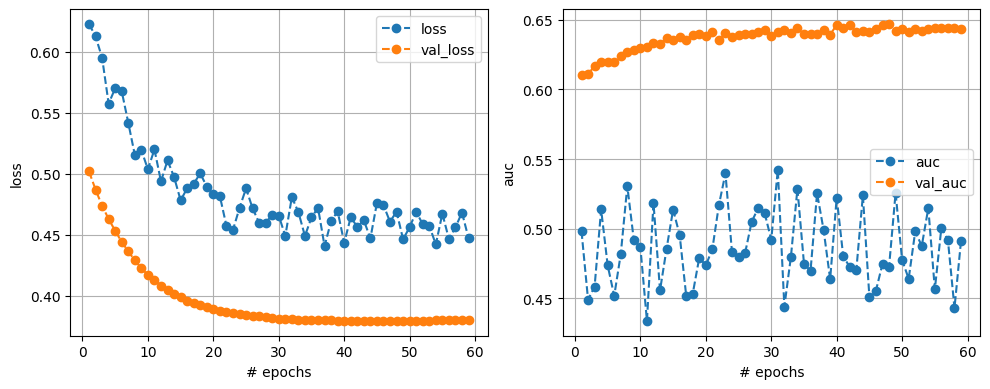

24/24 [==============================] - 4s 153ms/step - loss: 0.4472 - auc: 0.4913 - val_loss: 0.3801 - val_auc: 0.6434


In [30]:
# Extract the best hyperparameters
best_trial = study.best_trial.params

# Base model
base_mobilenet = tf.keras.applications.MobileNet(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Rebuild the model with the best hyperparameters
model = build_model(base_model=base_mobilenet, 
                    transfer_learning='Y', 
                    trial=optuna.trial.FixedTrial(best_trial))

# Callbacks
mb_callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)
mb_checkpoint = ModelCheckpoint('mb_best_weights.h5', save_best_only=True, save_weights_only=True)
mb_plot_callback = PlotLearning()

# Retrain the model
history = model.fit(prep_train_data,
                    epochs=150,
                    validation_data=prep_val_data,
                    callbacks=[mb_callback, mb_checkpoint, mb_plot_callback],
                   )

Best threshold: 0.00 with F1-score: 0.25


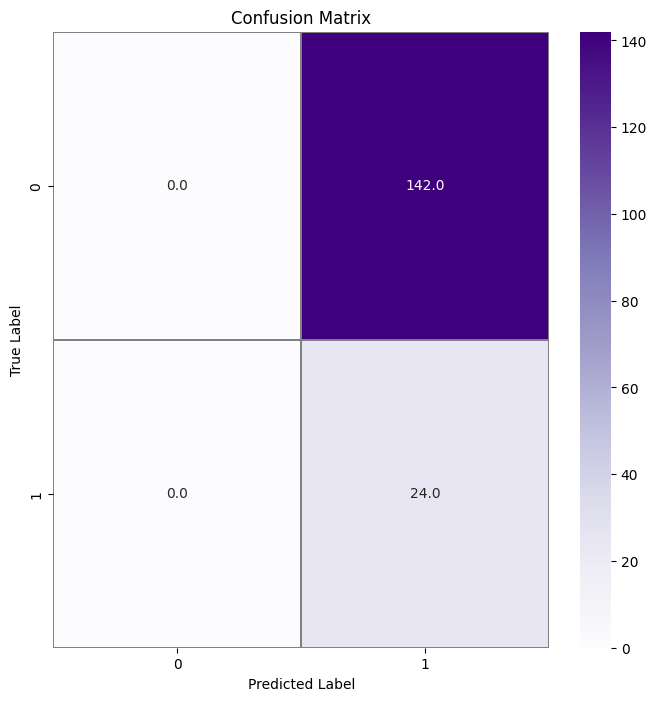

/tmp/ipykernel_42/1958539450.py:57: RuntimeWarning: invalid value encountered in scalar divide
  npv = TN / (TN + FN)
/tmp/ipykernel_42/1958539450.py:59: RuntimeWarning: invalid value encountered in scalar divide
  nlr = (1 - sensitivity) / specificity


              Model Name   AUC  F1-Score Positive Class  Accuracy  \
0  MobileNet-no-TL-tuned  0.38                     0.25      0.14   

   Sensitivity  Specificity   PPV  NPV  PLR  NLR  
0          1.0          0.0  0.14  NaN  1.0  NaN  


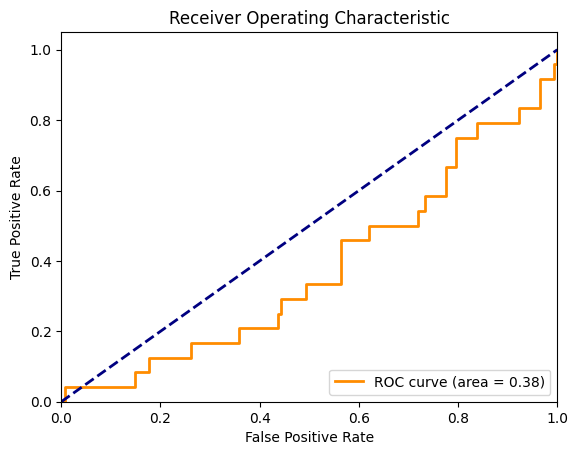

In [31]:
get_model_metrics(test_data=prep_test_data, model=model, model_name='MobileNet-no-TL-tuned')